# Spotify Çalma Listesi ile Yeni Benzer Bir Çalma Listesi Oluşturma

In [1]:
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.cluster import KMeans
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, HTML


## Veri Seti

Spotify öneri sistemi için kullanılan veri kümesi (data4.csv başlıklı), Spotify'da bulunan 1921-2020 yılları arasındaki 2.26 milyondan fazla parçadan oluşmaktadır. Kaggle kullanıcısı Sara Babu tarafından Spotify Millions Playlist'ten esinlenilerek toplanan veriler, Spotify Web API'dan ve scraping yöntemleri ile alınmış ve tablolaştırılmıştır. Veri kümesindeki her satır bir parçaya karşılık gelir ve URI, danceability, energy, key, loudness, mode, speechiness, accousticness, instrumentalness, liveness, valence, tempo, time_signature, duration_ms, popularity ve release_date gibi feature'lar ilgili sütunlarda yer alır. Bu temel değişkenlerle birlikte eksik olan name ve artists gibi değişkenler çalışma boyunca doldurulmuş ve birçok feature daha kullanılabilir hale getirilerek veri setinin ideal forma gelmesi sağlanmıştır. Çalışmanın güvenilirliğinin sağlanması amacıyla Spotify Millions veri seti, Yamaç Eren Ay'ın Spotify veri seti, Jefin Paul'un 170k'lık Spotify veri seti çalışmaları da testler boyunca kullanılmıştır.

Veri setini incelemek için çağıralım:


In [2]:
# Veri setlerini yükle
data = pd.read_csv('model/data/data4.csv')
data.head()


,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,popularity,release_date
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0.90,0.81,4,-7.11,0,0.12,0.03,0.01,0.05,0.81,125.46,4,226863,64,2005-07-04
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,0.77,0.84,5,-3.91,0,0.11,0.02,0.03,0.24,0.92,143.04,4,198800,78,2003-11-13
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0.66,0.76,2,-6.58,0,0.21,0.00,0.00,0.06,0.70,99.26,4,235933,18,2003-06-23
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,0.89,0.71,4,-6.05,0,0.14,0.20,0.00,0.05,0.82,100.97,4,267266,73,2002-11-04
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,0.85,0.61,0,-4.60,1,0.07,0.06,0.00,0.31,0.65,94.76,4,227600,0,2000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259837 entries, 0 to 2259836
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   uri               object 
 1   danceability      float64
 2   energy            float64
 3   key               int64  
 4   loudness          float64
 5   mode              int64  
 6   speechiness       float64
 7   acousticness      float64
 8   instrumentalness  float64
 9   liveness          float64
 10  valence           float64
 11  tempo             float64
 12  time_signature    int64  
 13  duration_ms       int64  
 14  popularity        int64  
 15  release_date      object 
dtypes: float64(9), int64(5), object(2)
memory usage: 275.9+ MB


### Veri Özellikleri ve İhtiyaç Duyacağımız Yeni Özellikleri Oluşturma
Veri setindeki değişkenler belirlenirken bir öneri listesi oluşturabilmemiz için ihtiyaç duyacağımız featurelar belirlenerek seçilmiştir, her satırdaki bir parçayı tanımlamakta ve her birine farklı parametreler arasında bize bir sayısal bağlam sağlar. Spotify'ın Web API'ından alınan parçanın ses özelliklerine dayanmaktadır.Aşağıda değişkenlerin listesi ve açıklamaları yer almaktadır:
- uri: Her parça için benzersiz bir tanımlayıcı.
- name: Şarkı ismi
- artists: Sanatçı ismi
- duration_ms: Parçanın milisaniye (ms) cinsinden uzunluğu.
- release_date: Parçanın MM/DD/YYYY veya en azından YYYY olarak yayınlanma tarihi.
- year: Parçanın yayınlandığı yıl.
- acousticness*: Parçanın akustik olup olmadığına dair 0,0 ile 1,0 arasında bir güven ölçüsü.
- danceability*: Bir parçanın dans için ne kadar uygun olduğunu açıklar. 0.0 değeri en az dans edilebilir, 1.0 değeri ise en çok dans edilebilir anlamına gelir.
- energy*: Enerji, 0,0 ila 1,0 arasında bir ölçüdür ve algısal olarak yoğunluk ve aktivite ölçüsünü temsil eder. Tipik olarak, enerjik parçalar hızlı ve gürültülü hissettirir.
- instrumentalness*: Bir parçanın vokal içerip içermediğini tahmin eder.
- liveness*: Kayıtta bir dinleyicinin varlığını tespit eder.
- loudness*: Desibel (dB) cinsinden bir parçanın genel ses yüksekliği.
- speachiness*: Bir parçada konuşulan kelimelerin varlığını algılar.
- tempo*: Bir parçanın dakika başına vuruş (BPM) cinsinden genel tahmini temposu.
- valence*: Bir parça tarafından aktarılan müzikal pozitifliği tanımlayan 0,0 ila 1,0 arasında bir ölçü.
- mode: Bir parçanın modalitesinden gelen melodik içerik. 1 = Majör; 0 = Minör.
- key: Pitch Class notasyonundan bir parçanın tahmini genel anahtarı. Örneğin 0 = C, 1 = C♯/D♭, 2 = D, vb.
- popularity: Bir parçanın popülerliği, Spotify'ın algoritmasına göre 100'ün en popüler olduğu 0-100 arası.
- explicit: Parçanın müstehcen sözlere sahip olup olmadığı. 1 = Doğru; 0 = Yanlış.

Burada incelenecek oldukça fazla değişken var, ancak burada aşağıdaki Keşifsel Veri Analizi ve Spotify verileri üzerinde İleri İnceleme ve Çıkarım ile ilgili olmayan tek sütun time_signature'dur. Basitlik adına, bu ilgisiz değişkeni drop ediyoruz. Veriyi daha rahat takip edebilmemiz için ilk olarak id eklemesi yapıyoruz ve ihtiyacımız olan sütunları düzenliyoruz:

In [4]:
data = data.dropna()
data['id'] = range(1, len(data) + 1)
desired_columns = ['id', 'uri', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'release_date', 'speechiness', 'tempo', 'valence', 'popularity']
data = data[desired_columns]

Tarih verisini kullanabileceğimiz bir format olan yıl formatına dönüştürüyoruz:

In [5]:
# 'YYYY' formatındaki değerleri 'YYYY-01-01' tarih formatına dönüştür
mask = data['release_date'].str.len() == 4
data.loc[mask, 'release_date'] = pd.to_datetime(data.loc[mask, 'release_date'] + '-01-01', errors='coerce')

# Yıl sütununu ekleyerek tarihi çıkart
data['year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year
data['year']



0         2005.00
1         2003.00
2         2003.00
3         2002.00
4         2000.00
            ...  
2259832   2015.00
2259833   2016.00
2259834   2016.00
2259835   2017.00
2259836   2015.00
Name: year, Length: 2259837, dtype: float64

Key ve mode bu haliyle kullanıma uygun olmadığından dolayı letter versiyonuna dönüştürüyoruz ve yılı da decade olarak bir aralık olarak kullanmak istediğimizden dolayı yıl aralıklarına dönüştürüyoruz.

In [6]:
# key ve mode sütunlarını seslere çevir
keys = {0:'C', 1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}
modes = {0:'Minor',1:'Major'}

# yeni sütunları ekle
data['letter_keys'] = data['key'].map(keys)
data['modes'] = data['mode'].map(modes)

# key ve mode sütunlarını birleştir yeni bir sütun oluştur
data['key_mode'] = data['letter_keys'] + " " + data['modes']
data['decade'] = data['year'].apply(lambda x: str(x)[:3]+'0')

### Aykırı Değer Düzenleme
Eşik değer ortalamasından 5 aşağı ve yukarı olacak şekilde standart sapma uyguluyoruz ve aykırı değerleri (outliers) düzenliyoruz. Aykırı değerler, genellikle bir veri setindeki diğer değerlerden önemli ölçüde farklı olan değerlerdir. Bu değerler, genellikle veri analizi ve modelleme süreçlerinde bize engel olabiliyor.
Bundan dolayıı, veri setindeki sayısal sütunlarseçipve her bir sütun için, değerlerin ortalamasının 5 standart sapma üzerinde veya altında olan değerlerbuluyoruzur. Standart sapma, bir veri setindeki değerlerin ne kadar yayıldığınölçtüğünden,ro Ortalamanın 5 standart sapma üzerinde veya altında olan değerler, genellikle aykırı değerler olarak kabuediyoruzi 

Bu değerler bulunduktan sonra, np.select fonksiyonu kullanılarak bu aykırı değerler, sırasıyla ortalamasının 5 standart sapma üzerinde veya altında olan değerlerle değiştirilir. Bu, aykırı değerlerin etkisini azaltır ve veri setinin genel dağılımını daha iyi temsil etmesini sağlidir.

In [7]:
numerical_cols = data.select_dtypes(include=[np.number]).columns
for feat in numerical_cols:
    abv_5_std = data[feat].mean()+ 5* data[feat].std()
    below_5_std = data[feat].mean()- 5* data[feat].std()
    conditions = [data[feat]>abv_5_std, data[feat]<below_5_std]
    choices = [abv_5_std, below_5_std]
    data[feat] = np.select(conditions, choices, data[feat])

Ardından veri setinin son haline bir göz atalım:

In [8]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259837 entries, 0 to 2259836
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   uri               object 
 2   acousticness      float64
 3   danceability      float64
 4   duration_ms       float64
 5   energy            float64
 6   instrumentalness  float64
 7   key               float64
 8   liveness          float64
 9   loudness          float64
 10  mode              float64
 11  release_date      object 
 12  speechiness       float64
 13  tempo             float64
 14  valence           float64
 15  popularity        float64
 16  year              float64
 17  letter_keys       object 
 18  modes             object 
 19  key_mode          object 
 20  decade            object 
dtypes: float64(15), object(6)
memory usage: 362.1+ MB


,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,year
count,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2259837.00,2254504.00
mean,1129919.00,0.35,0.55,244112.67,0.58,0.22,5.26,0.21,-9.65,0.66,0.09,119.99,0.48,7.26,2007.61
std,652358.89,0.35,0.18,111411.61,0.27,0.35,3.56,0.19,5.59,0.48,0.10,29.92,0.27,11.46,10.67
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-37.78,0.00,0.00,0.00,0.00,0.00,1953.53
25%,564960.00,0.02,0.43,184156.00,0.39,0.00,2.00,0.10,-11.91,0.00,0.04,96.94,0.25,0.00,2005.00
50%,1129919.00,0.21,0.56,225200.00,0.62,0.00,5.00,0.13,-8.18,1.00,0.05,120.01,0.47,1.00,2011.00
75%,1694878.00,0.69,0.69,278203.00,0.81,0.42,8.00,0.26,-5.83,1.00,0.08,138.06,0.70,11.00,2014.00
max,2259837.00,1.00,1.00,1037414.29,1.00,1.00,11.00,1.00,4.92,1.00,0.67,249.99,1.00,64.68,2022.00


### Veri Normalleştirme
Sırada veri normalleştirme işlemi gerçekleştirilmesi var. Normalleştirme işlemini farklı ölçeklere sahip olan veri özelliklerini (features) ortak bir ölçeğe getirmek için kullanıyoruz.

Aşağıdaki yöntemde min-max normalleştirme tekniğini kullanıyoruz. Bu teknik, bir özelliğin değerlerini 0 ile 1 arasında bir aralığa ölçeklendirir. Bu, aşağıdaki formül ile yapılır:

 - (x - min(x)) / (max(x) - min(x))

Bu formül, x değerinin özelliğin minimum değerinden çıkarılması ve sonucun özelliğin maksimum değeri ile minimum değeri arasındaki farka bölünmesi ile çalışır. Bu, x değerini 0 ile 1 arasında bir değere dönüştürür.

Bu işlemi veri setindeki bir dizi özellik için gerçekleştiriyoruz bunlar: 'speechiness', 'duration_ms', 'instrumentalness', 'loudness', 'tempo', 'energy', 'danceability' ve 'popularity'. Her özellik için, normalleştirilmiş değerler yeni bir sütunda saklanacak şekilde işlemi tamamlıyoruz. Bu yeni sütunların adları, orijinal özellik adlarına 'scaled_' öneki eklenerek oluşturuyoruz.

Bu normalleştirme işlemi sayesinde veri setindeki özelliklerin farklı ölçeklerde olmasından kaynaklanabilecek potansiyel sorunları önlemeyi amaçlıyoruz. Veri setinin özelliği gereği bazı feature'lar farklı ölçeklere sahip olduğundna dolayı, karşılıklı olarak birbirleriyle karşılaştırılması veya birbirleriyle birleştirilmesi gereken durumlardaki kararsızlık veya yanlış heaplamaları önleyerek performansı iyileştiriyor.

In [9]:
data['scaled_speech'] = (data['speechiness'] - min(data['speechiness'])) / (max(data['speechiness']) - min(data['speechiness']))
data['scaled_duration'] = (data['duration_ms'] - min(data['duration_ms'])) / (max(data['duration_ms']) - min(data['duration_ms']))
data['scaled_instrumentalness'] = (data['instrumentalness'] - min(data['instrumentalness'])) / (max(data['instrumentalness']) - min(data['instrumentalness']))
data['scaled_loudness'] = (data['loudness'] - min(data['loudness'])) / (max(data['loudness']) - min(data['loudness']))
data['scaled_tempo'] = (data['tempo'] - min(data['tempo'])) / (max(data['tempo']) - min(data['tempo']))
data['scaled_energy'] = (data['energy'] - min(data['energy'])) / (max(data['energy']) - min(data['energy']))
data['scaled_danceability'] = (data['danceability'] - min(data['danceability'])) / (max(data['danceability']) - min(data['danceability']))
data['scaled_popularity'] = (data['popularity'] - min(data['popularity'])) / (max(data['popularity']) - min(data['popularity']))


### Dummy ile One-hot kodlama
Dummyler oluşturarak sayısal olmayan verilerin hesaplanabilmesi için uygun ortamı hazırlayalım. Kategorik değişkenleri one-hot olarak kodlayarak sayısal formata dönüştürelim. 'key_mode' ve 'decade' adlı iki kategorik değişkenine de aynı işlemi uygulayalım sonra bu yeni dummy sütunları orijinal veri çerçevesine ekleyelim.

In [10]:
key_dummies = pd.get_dummies(data['key_mode'], drop_first=True)
decade_dummies = pd.get_dummies(data['decade'], drop_first=False)
data = pd.concat([data, key_dummies, decade_dummies], axis=1)
# 1980's'den 2020's'e kadar olan decadeleri ekle
decades = ['1960','1970','1980', '1990', '2000', '2010', '2020']
for decade in decades:
    if decade not in data.columns:
        data[decade] = False

### Son Hale Getirme
İhtiyacımız olan tüm columnları istediğimiz sıraya getirerek veriyi işlenmeye hazır hale getirelim.

In [11]:
desired_columns = ['id', 'uri', 'popularity', 'instrumentalness', 'key', 'liveness', 'danceability', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'energy', 'release_date',  'year', 'decade', 'letter_keys', 'modes', 'key_mode', 'scaled_speech', 'scaled_danceability', 'scaled_instrumentalness', 'scaled_duration', 'scaled_loudness', 'scaled_tempo', 'scaled_energy', 'scaled_popularity', 'A Minor', 'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor', 'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor', 'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor', 'F# Major', 'F# Minor', 'G Major', 'G Minor','1960', '1970', '1980', '1990', '2000', '2010', '2020']
data = data[desired_columns]

Son halinin çıktısı aşığıdaki gibi olacaktır

In [12]:
data = data.dropna()
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Index: 2254504 entries, 0 to 2259836
Data columns (total 57 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       float64
 1   uri                      object 
 2   popularity               float64
 3   instrumentalness         float64
 4   key                      float64
 5   liveness                 float64
 6   danceability             float64
 7   loudness                 float64
 8   mode                     float64
 9   speechiness              float64
 10  tempo                    float64
 11  valence                  float64
 12  energy                   float64
 13  release_date             object 
 14  year                     float64
 15  decade                   object 
 16  letter_keys              object 
 17  modes                    object 
 18  key_mode                 object 
 19  scaled_speech            float64
 20  scaled_danceability      float64
 21  scaled_instru

,id,uri,popularity,instrumentalness,key,liveness,danceability,loudness,mode,speechiness,...,F# Minor,G Major,G Minor,1960,1970,1980,1990,2000,2010,2020
0,1.00,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,64.00,0.01,4.00,0.05,0.90,-7.11,0.00,0.12,...,False,False,False,False,False,False,False,True,False,False
1,2.00,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,64.68,0.03,5.00,0.24,0.77,-3.91,0.00,0.11,...,False,False,False,False,False,False,False,True,False,False
2,3.00,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,18.00,0.00,2.00,0.06,0.66,-6.58,0.00,0.21,...,False,False,False,False,False,False,False,True,False,False
3,4.00,spotify:track:1AWQoqb9bSvzTjaLralEkT,64.68,0.00,4.00,0.05,0.89,-6.05,0.00,0.14,...,False,False,False,False,False,False,False,True,False,False
4,5.00,spotify:track:1lzr43nnXAijIGYnCT8M8H,0.00,0.00,0.00,0.31,0.85,-4.60,1.00,0.07,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259832,2259833.00,spotify:track:5wIzEF7fP5qHlaHPtZtjgZ,10.00,0.00,8.00,0.26,0.65,-8.73,0.00,0.19,...,False,False,False,False,False,False,False,False,True,False
2259833,2259834.00,spotify:track:3Hk3aKs0JGR4BKHSoBwnA9,3.00,0.00,11.00,0.50,0.81,-6.23,0.00,0.08,...,False,False,False,False,False,False,False,False,True,False
2259834,2259835.00,spotify:track:719DKMPmy7HxikHdzbfiI2,2.00,0.00,9.00,0.48,0.67,-1.50,0.00,0.27,...,False,False,False,False,False,False,False,False,True,False
2259835,2259836.00,spotify:track:0T4xJPTJdNd5cPwHdPCIGU,12.00,0.00,6.00,0.21,0.61,-3.08,0.00,0.30,...,True,False,False,False,False,False,False,False,True,False


In [13]:
data.describe(include='all')

,id,uri,popularity,instrumentalness,key,liveness,danceability,loudness,mode,speechiness,...,F# Minor,G Major,G Minor,1960,1970,1980,1990,2000,2010,2020
count,2254504.00,2254504,2254504.00,2254504.00,2254504.00,2254504.00,2254504.00,2254504.00,2254504.00,2254504.00,...,2254504,2254504,2254504,2254504,2254504,2254504,2254504,2254504,2254504,2254504
unique,NaN,2254504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,2
top,NaN,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2189421,2035404,2195594,2227540,2210114,2189950,2062153,1683695,1343236,2254381
mean,1130111.35,NaN,7.26,0.22,5.26,0.21,0.55,-9.65,0.65,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,652343.60,NaN,11.46,0.35,3.56,0.19,0.18,5.59,0.48,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.00,NaN,0.00,0.00,0.00,0.00,0.00,-37.78,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,565215.75,NaN,0.00,0.00,2.00,0.10,0.43,-11.90,0.00,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1130268.50,NaN,1.00,0.00,5.00,0.13,0.56,-8.17,1.00,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1695045.25,NaN,11.00,0.42,8.00,0.26,0.69,-5.82,1.00,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Popülerlik ile diğer özellikler arasındaki genel ilişki
Spotify şarkılarının popülerliği ile diğer özelliklerinin arasındaki ilişkiyi gösteren bir korelasyon matrisi oluşturalım. Matristeki değerler, her iki özelliğin birbirine olan bağımlılığını gösterir.

Matristeki değerleri daha yakından incelediğimizde, popülerlik ile aşağıdaki özellikler arasında güçlü bir ilişki olduğunu görüyoruz:

Yıl: Popüler şarkılar genellikle daha eski şarkılardır.
Tempo: Popüler şarkılar genellikle hızlı tempoya sahiptir.
Enerji: Enerjik şarkılar genellikle yüksek popülaritiye sahiptir.
Valence: Pozitif duygular uyandıran şarkılar daha yüksek popülariteye sahiptir
Dans edilebilirlik: Popüler şarkılar genellikle dans edilebilirdir.
Enstrümentalite: Popüler şarkılar enstrümental ve sözsüz şarkılar değildir.
Seslilik: Popüler şarkılar daha yoğun seslilik değerine sahiptir
E-major, E-minor, D-minor ve D-major daha popüler key-mode değerleridir

Popüler şarkılar genellikle daha 1990 ve sonrası ama 2020'ler öncesi, popüler türlerde, hızlı tempolu, yüksek enerjili ve dans edilebilirdir. Bu özellikler, şarkıların daha fazla dinlenmesine ve daha popüler olmasını sağlar.


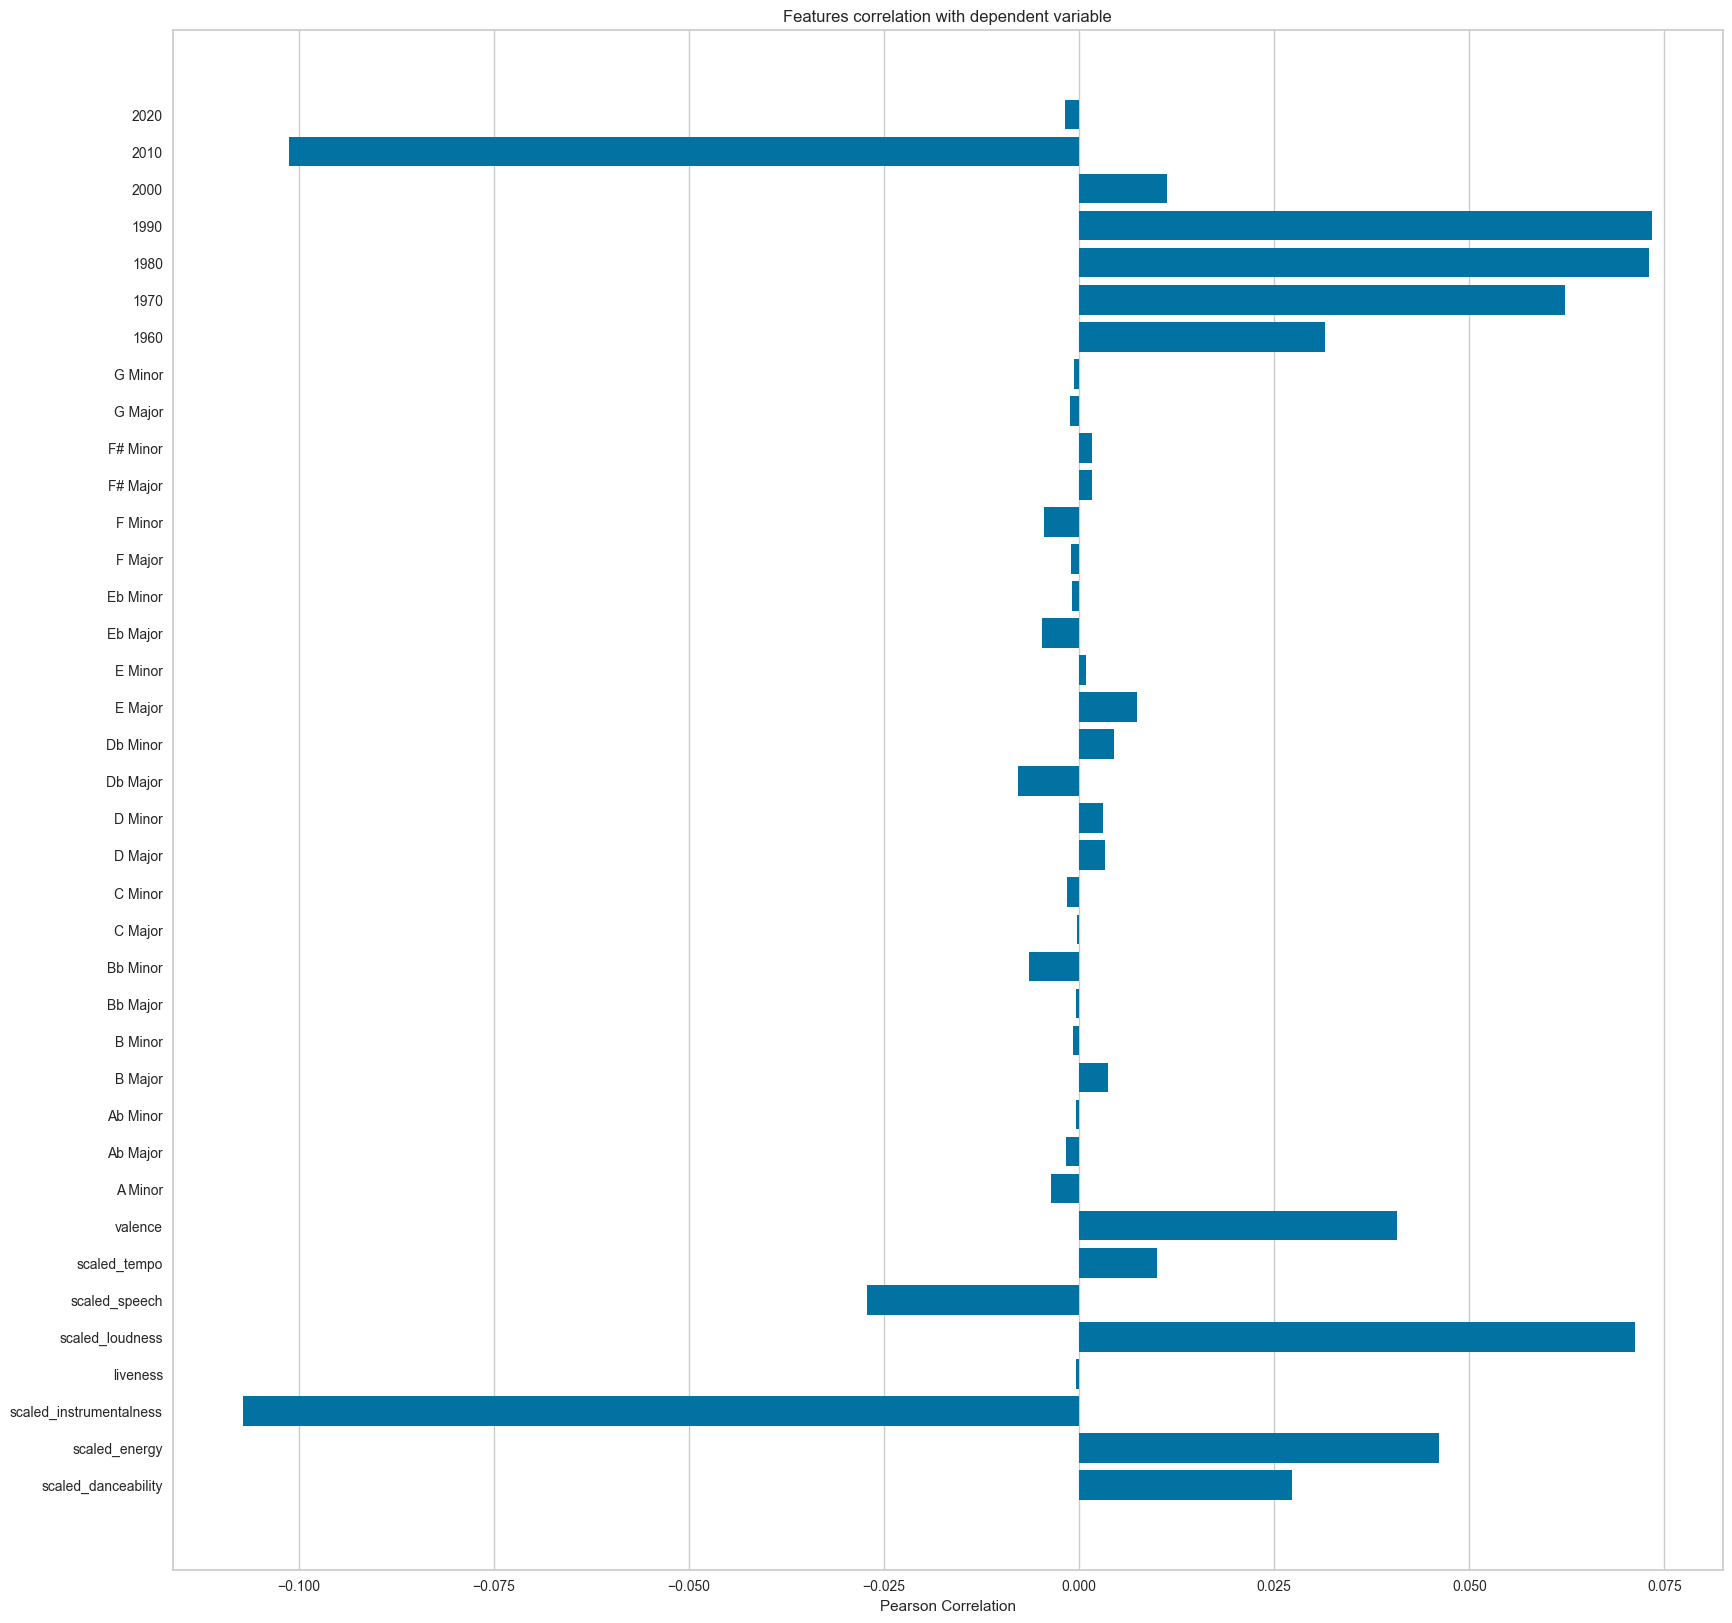

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [14]:

feature_names = ['scaled_danceability', 'scaled_energy', 'scaled_instrumentalness',
       'liveness', 'scaled_loudness', 'scaled_speech', 'scaled_tempo', 'valence','A Minor', 'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor', 'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor', 'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor', 'F# Major', 'F# Minor', 'G Major', 'G Minor','1960', '1970', '1980', '1990', '2000', '2010', '2020' ]

X, y = data[feature_names], data['scaled_popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

### Yıl dağılımı
Veri setindeki şarkıların genel olarak yıl dağılımı 2000'ler ve 2010'lardır.

<Axes: xlabel='count', ylabel='decade'>

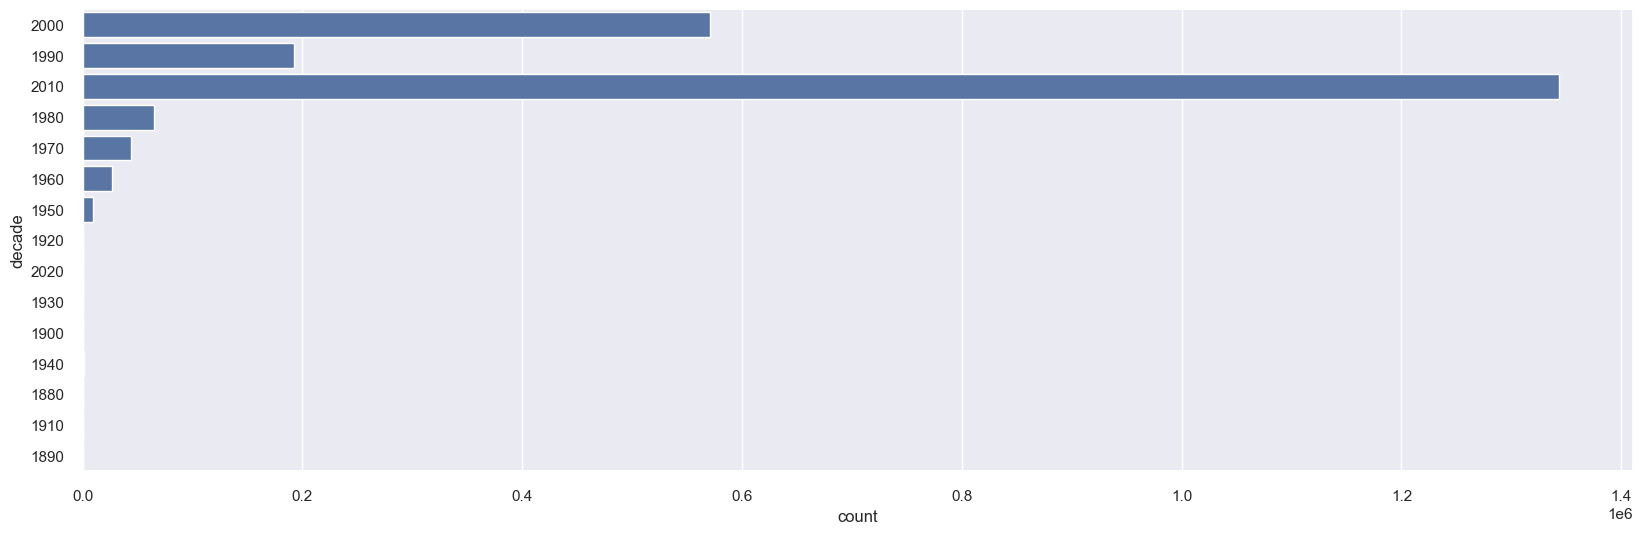

In [15]:
sns.set(rc={'figure.figsize':(20 ,6)})
sns.countplot(data['decade'])




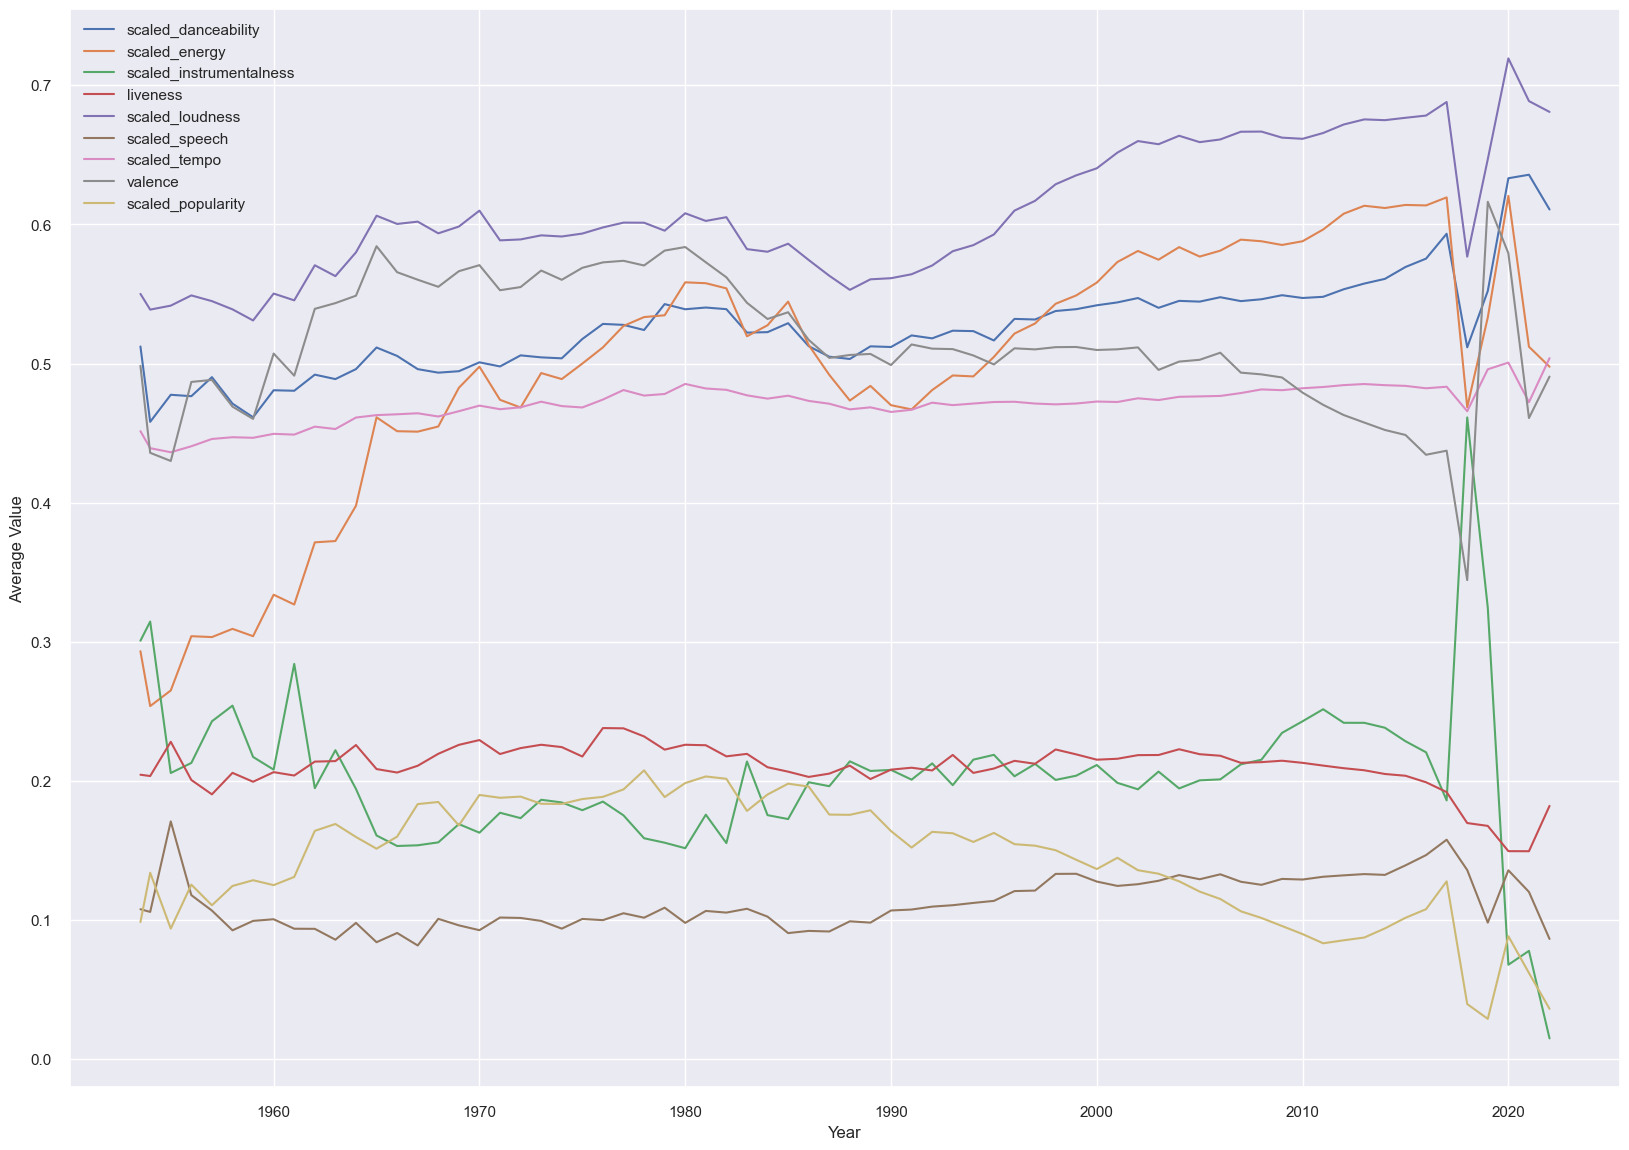

In [16]:
sound_features = ['scaled_danceability', 'scaled_energy', 'scaled_instrumentalness',
                  'liveness', 'scaled_loudness', 'scaled_speech', 'scaled_tempo', 'valence', 'scaled_popularity']

# Yıllara göre özelliklerin ortalamasını alma
average_features = data.groupby('year')[sound_features].mean().reset_index()

# Her bir özelliği ayrı çizgiyle çizme
plt.figure(figsize=(20, 14))
for feature in sound_features:
    plt.plot(average_features['year'], average_features[feature], label=feature)

plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.show()


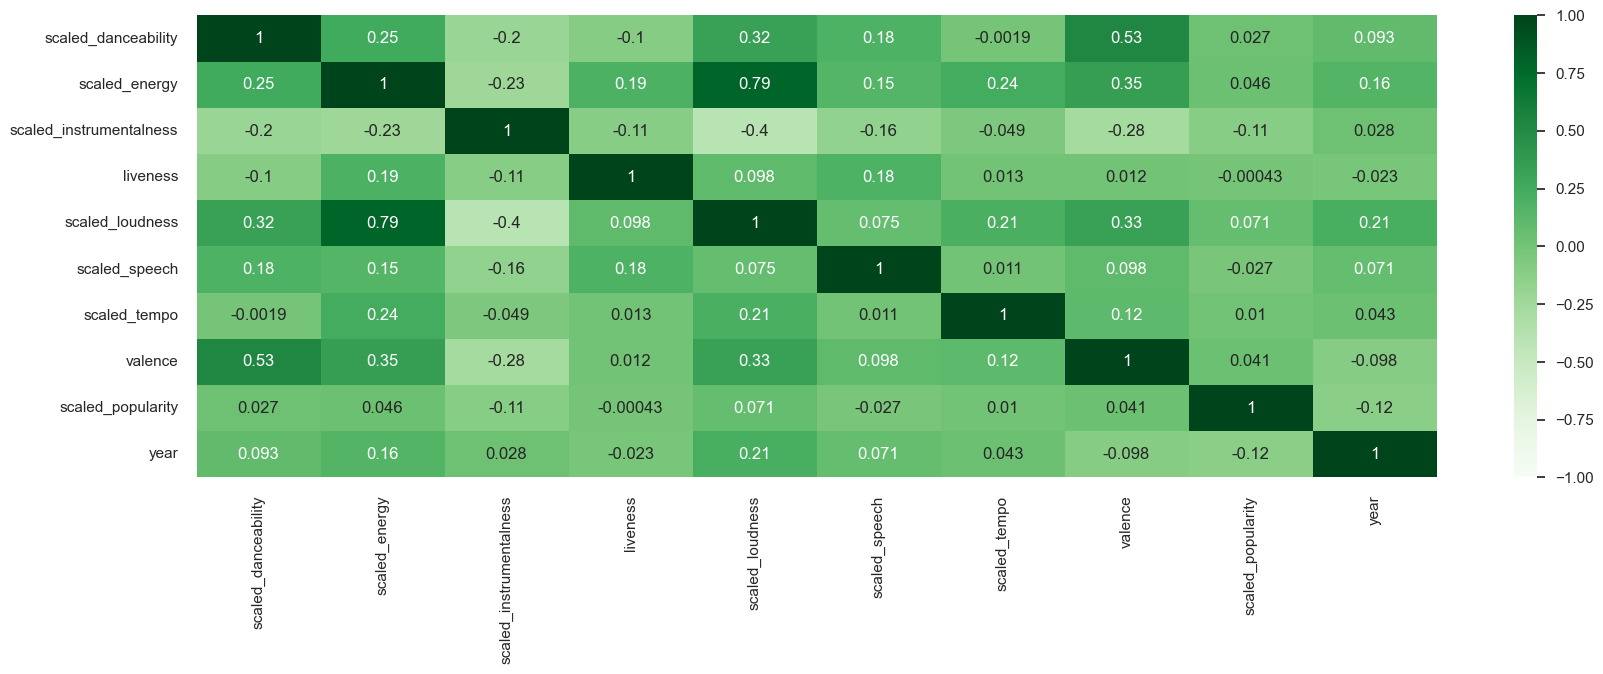

In [17]:
numeric_columns = data.select_dtypes(include=['int', 'float']).columns

sound_features = ['scaled_danceability', 'scaled_energy', 'scaled_instrumentalness',
                  'liveness', 'scaled_loudness', 'scaled_speech', 'scaled_tempo', 'valence', 'scaled_popularity', 'year']

# Belirli özellikleri içeren sütunları seçerek korelasyon matrisini oluştur
correlation_matrix = data[sound_features].corr()

# Korelasyon matrisini görselleştir
plt.figure(figsize=(20, 6))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap="Greens")
plt.show()